In [260]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from scipy.interpolate import interp1d
from functools import cache

import matplotlib

%matplotlib inline

matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (14,9)
matplotlib.rcParams['savefig.bbox'] = 'tight'

import distr

In [346]:
# https://paimon.moe/wish/tally/300013
#  Eula char banner
paimonmoe = [122,107,109,118,100,103,103,103,107,116,104,87,96,87,95,86,86,107,95,90,99,64,88,87,74,71,79,87,77,74,77,76,93,76,71,91,67,87,79,81,86,59,78,53,89,74,88,88,71,73,76,73,81,73,88,69,67,76,78,62,74,63,81,78,86,54,63,64,70,71,66,68,56,732,1266,1662,1733,1655,1453,1074,773,415,207,104,44,14,3,1,1,1]
print(sum(paimonmoe))
pm = np.array(paimonmoe) / sum(paimonmoe)

17153


In [22]:
@cache
def e_5s(w):
    def e5_phw(w):
        if 1 <= w <= 73:
            return .006
        elif 73 <= w <= 90:
            return .006 + (1-.006)/17 * (w-73)
        else:
            return 0
    return np.prod([1-e5_phw(w2) for w2 in range(w)]) * e5_phw(w)

In [358]:
# https://paimon.moe/wish/tally/300013/
#  Eula char banner
pai = [6652, 6294, 5919, 5678, 5243, 4875, 4731, 4474, 46038, 35283]
print(sum(pai))
pm = np.array(pai) / sum(pai)

125187


In [444]:
def e4_phw(w):
    if 1 <= w <= 8:
        return .051
#     elif 8 <= w <= 10:
#         return .051 + (1 - .051)/2 * (w-8)
    elif w == 9:
        return 13/23
    elif w == 10:
        return 1
    return 0

@cache
def e_4s(w):
    return np.prod([1-e4_phw(w2) for w2 in range(w)]) * e4_phw(w)

In [348]:
# https://paimon.moe/wish/tally/400008
#  Homa weapon banner
paimonmoe = [144,124,134,131,126,132,143,144,123,130,140,125,117,115,112,110,123,120,114,112,92,106,113,82,83,93,93,110,93,93,79,84,95,88,78,81,94,68,75,73,95,79,68,90,72,75,73,73,61,83,64,64,70,87,85,94,87,80,71,63,61,90,622,1169,1370,1369,1270,896,545,308,179,62,28,4,4,2,2,1,1,1,0,1,1,2,0,0,1,0,0,0]
paaaaaaaa = [87,80,84,85,103,88,100,95,74,86,85,76,78,69,69,79,66,82,59,65,63,50,60,67,64,54,68,65,53,66,65,58,58,54,58,47,61,52,52,68,56,56,58,55,53,59,53,49,50,47,53,58,51,76,57,63,59,63,64,53,63,71,456,807,989,1026,911,679,487,277,132,51,22,6,3,3,1,1,1,2,2,2,0,0,0,0,0,2,1,0]
pm = np.array(paimonmoe) + np.array(paaaaaaaa)
print(np.sum(pm))
pm = pm / np.sum(pm)

23736


In [268]:
pts = [[0, .009], [1, .07978], [7,.49], [10, .55], [13, .24], [16, .1], [28, 1]]
x, y = np.array(pts).T
cinterp = interp1d(x+62, y, kind='cubic')
def w5_phw(w):
#     w = w - 1
    if 1 <= w <= 62:
        return .009
    elif 62 <= w <= 90:
        return cinterp(w)
    else:
        return 0

@cache
def w_5s(w):
    return np.prod([1-w5_phw(w2) for w2 in range(w)]) * w5_phw(w)

In [446]:
pai = [5299, 5000, 4528, 4334, 4097, 3937, 3420, 34043, 16912, 180]
print(sum(pai))
pm = np.array(pai) / sum(pai)

81750


In [471]:
def w4_phw(w):
    if 1 <= w <= 7:
        return .06
    if w == 8:
        return 2/3
    elif w == 9:
        return .9895
    elif w == 10:
        return 1
    return 0

@cache
def w_4s(w):
    return np.prod([1-w4_phw(w2) for w2 in range(w)]) * w4_phw(w)

In [472]:
stdevs = np.sqrt(pm * (1-pm) / sum(pai))
margins = np.array([pm[n] / (1-sum(pm[:n])) for n in range(1, 10)])

In [473]:
e_5s_multi = distr.MultiDistr(e_5s, 90)
e_4s_multi = distr.MultiDistr(e_4s, 10)
w_5s_multi = distr.MultiDistr(w_5s, 90)
w_4s_multi = distr.MultiDistr(w_4s, 10)

In [498]:
def e4_pan(n: int) -> float:
    if n == 0: return 0

    a2 = -.5 - 2 / (np.sqrt(13))
    a3= -.5 + 2 / (np.sqrt(13))
    l2 = (1+np.sqrt(13))/6
    l3 = (1-np.sqrt(13))/6
    return a2 * (l2-1) * l2**(n-1) + a3 * (l3-1) * l3**(n-1)

@cache
def e_4s_hit(w):
    return sum([e4_pan(n) * e_4s_multi.p_iter(w, n) for n in range(w+1)])

In [551]:
def w_pan(n: int) -> float:
    if n == 0: return 0

    a2 = -.5 - 11/(4*np.sqrt(29))
    a3 = -.5 + 11/(4*np.sqrt(29))
    l2 = (3+np.sqrt(29)) / 10
    l3 = (3-np.sqrt(29)) / 10
    return a2 * (l2-1) * l2**(n-1) + a3 * (l3-1) * l3**(n-1)

@cache
def w_4s_hit(w):
    return sum([w_pan(n) * w_4s_multi.p_iter(w, n) for n in range(w+1)])

In [554]:
np.sum([w_4s_hit(w) for w in range(1, 500)])

0.9999973338592171

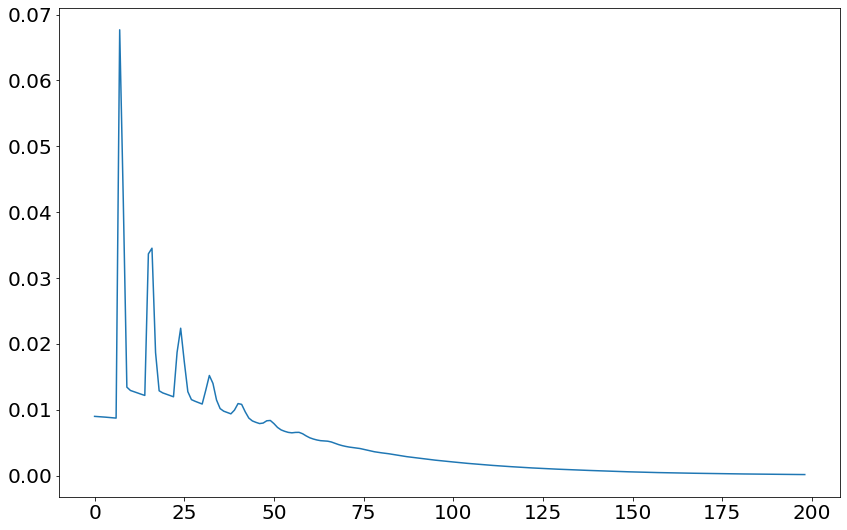

In [553]:
plt.plot([w_4s_hit(w) for w in range(1, 500)])

In [506]:
e_4s_hit(140) / e_4s_hit(139)

0.9676941978018309

In [530]:
e_4s_hit(309) / e_4s_hit(308)

0.9666134730409572

In [542]:
np.sum(np.arange(600) * [e_4s_hit(w) for w in range(600)])

34.43677825530884

In [546]:
cdf = np.cumsum([e_4s_hit(w) for w in range(600)])

In [549]:
cdf[25]

0.49551226876215676

In [550]:
np.argmin(np.abs(cdf - .8))

52

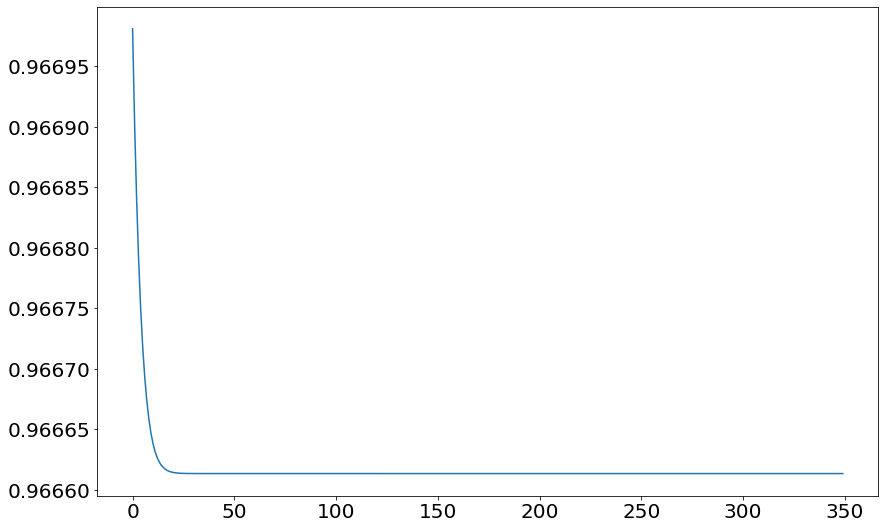

In [529]:
plt.plot([e_4s_hit(w) / e_4s_hit(w-1) for w in range(200, 550)])
# plt.plot([0, 300], [l2, l2])

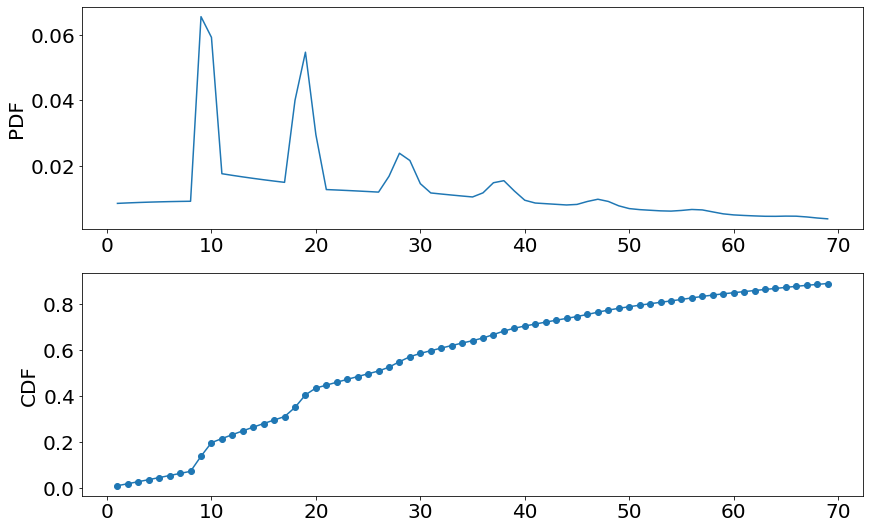

In [532]:
plt.subplot(211)
plt.plot(range(1, 70), [e_4s_hit(w) for w in range(1, 70)])
plt.ylabel('PDF')

plt.subplot(212)
plt.plot(range(1, 70), np.cumsum([e_4s_hit(w) for w in range(1, 70)]), marker='o')
plt.ylabel('CDF')

plt.savefig('4s_targ_dist.png')
# l2 = (1+np.sqrt(13))/6
# plt.plot(range(1, 150), [-np.log(l2) * l2**n for n in range(1, 150)])

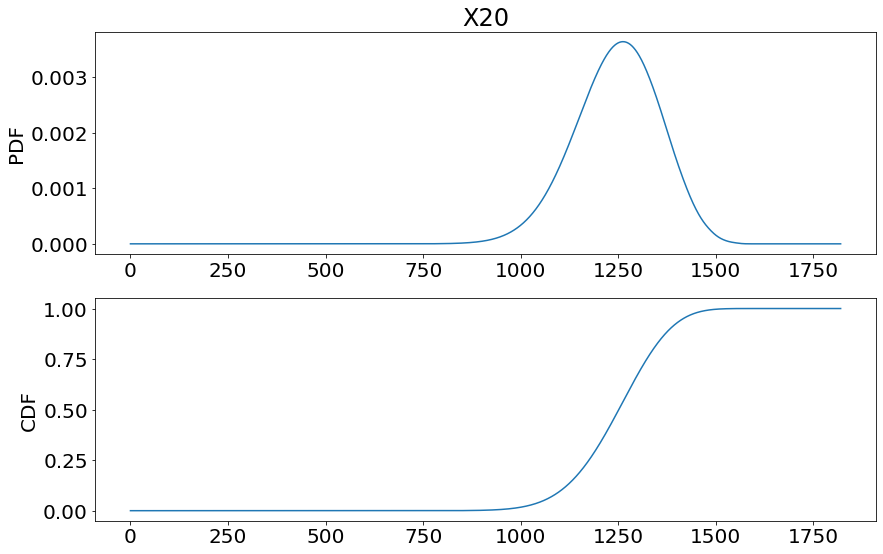

In [497]:
i = 20
plt.subplot(211)
plt.plot(e_5s_multi.get_distr(i))
plt.title(f'X{i}')
plt.ylabel('PDF')
plt.subplot(212)
plt.plot(np.cumsum(e_5s_multi.get_distr(i)))
plt.ylabel('CDF')

plt.savefig(f'pdfcdf{i}.png')

In [476]:
w_4s_multi.mean, w_4s_multi.std

(6.725613227292525, 2.5161877507433426)

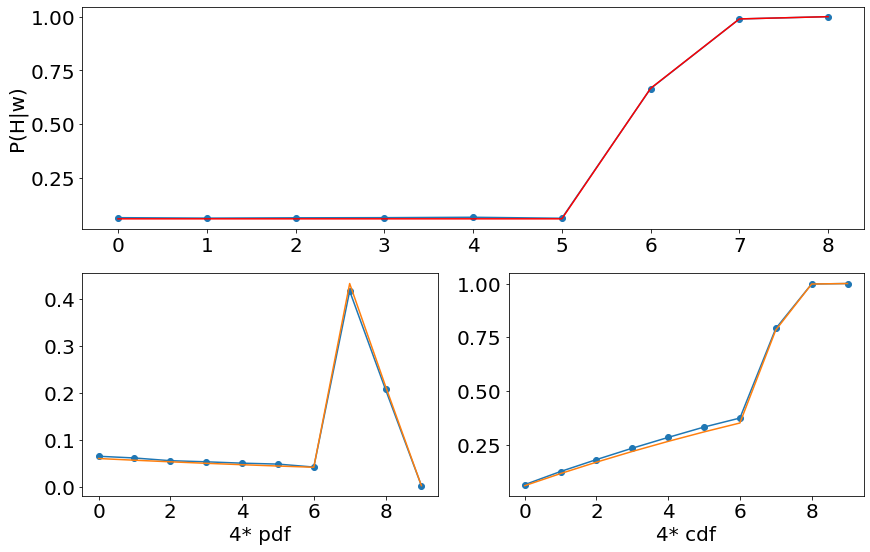

In [477]:
plt.subplot(211)
ml = np.array([(pm[n] - stdevs[n]) / (1-sum(pm[:n])) for n in range(1, 10)])
mr = np.array([(pm[n] + stdevs[n]) / (1-sum(pm[:n])) for n in range(1, 10)])
plt.plot(margins, marker='o')
# plt.plot(ml, color='orange')
# plt.plot(mr, color='orange')

plt.plot([w4_phw(n) for n in range(2, 11)], color='red')
plt.ylabel('P(H|w)')

plt.subplot(223)
plt.plot(pm, marker='o')
plt.plot(w_4s_multi.get_distr(1)[1:-1])
plt.xlabel('4* pdf')

plt.subplot(224)
plt.plot(np.cumsum(pm), marker='o')
plt.plot(np.cumsum(w_4s_multi.get_distr(1)[1:-1]))
plt.xlabel('4* cdf')
plt.savefig('w4_margin.png')

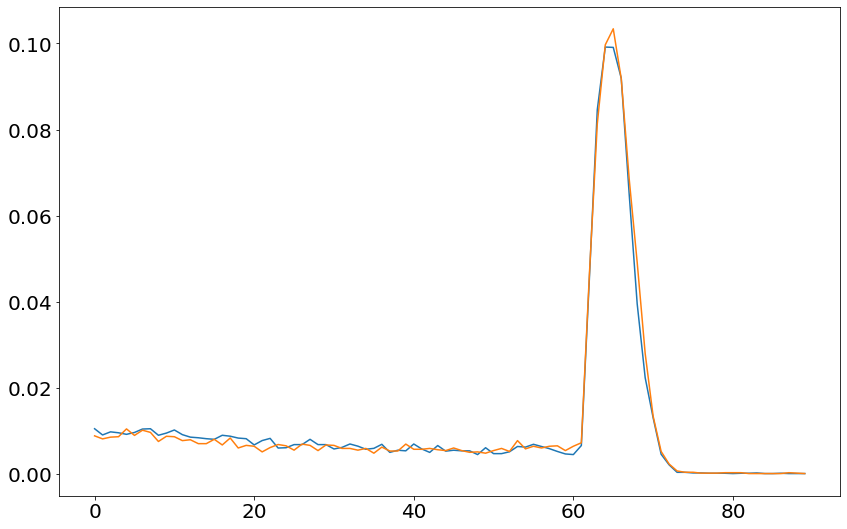

In [317]:
plt.plot(np.array(paimonmoe) / np.sum(paimonmoe))
plt.plot(np.array(paaaaaaaa) / np.sum(paaaaaaaa))


In [25]:
paimonmoe.index(622)

62

In [54]:
stdevs = np.sqrt(pm * (1-pm) / sum(paimonmoe))
margins = np.array([pm[n] / (1-sum(pm[:n])) for n in range(1, 90)])

In [64]:
paaaaaaaa[76] + paimonmoe[76]

3

-3.2121613249441665e-05

In [322]:
w_5s(90)

3.547752304461289e-08

In [324]:
sum([w_5s(w) for w in range(1,92)])

0.9999999999999993

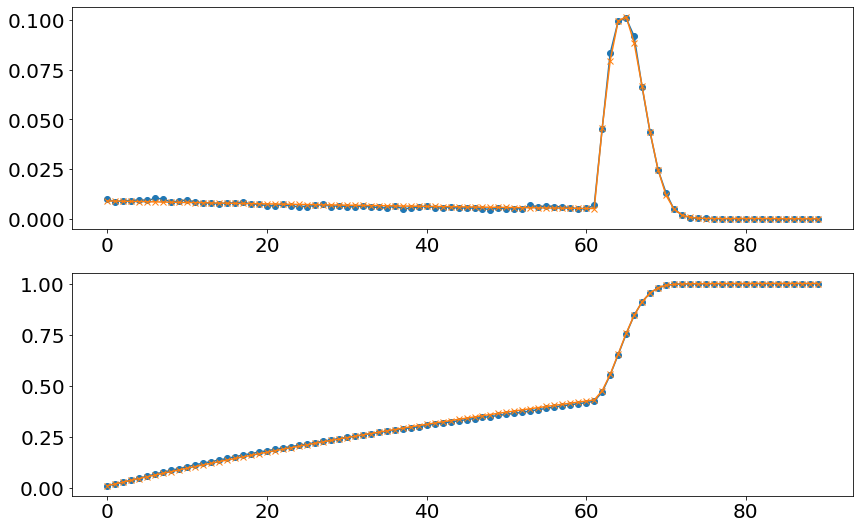

In [356]:
plt.subplot(211)
plt.plot(pm, marker='o')
plt.plot([w_5s(w) for w in range(1,91)], marker='x')

plt.subplot(212)
plt.plot(np.cumsum(pm), marker='o')
plt.plot(np.cumsum([w_5s(w) for w in range(1,91)]), marker='x')
plt.savefig('w5_pc1.png')

In [266]:
.009 + (1-.009)/(76-62)

0.07978571428571428

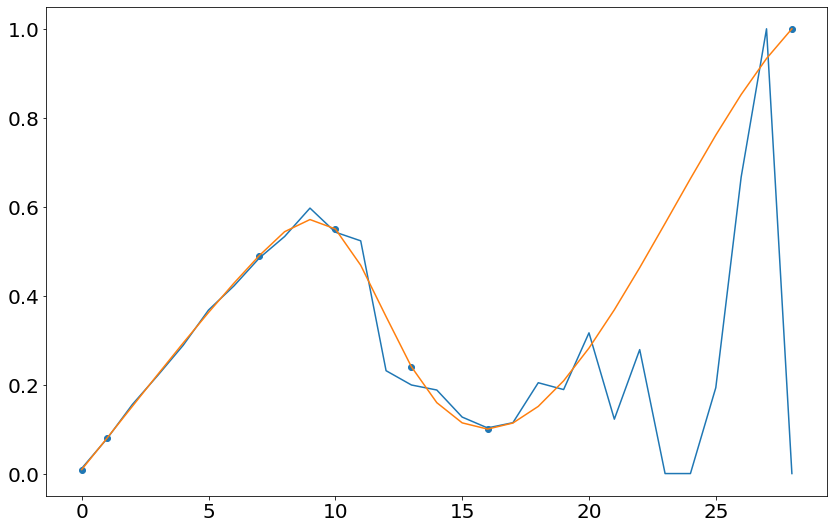

In [267]:
x = np.arange(29)

plt.plot(f)

pts = [[0, .009], [1, .07978], [7,.49], [10, .55], [13, .24], [16, .1], [28, 1]]
pts = np.array(pts)
lint = interp1d(*pts.T, kind='cubic')

plt.scatter(*pts.T)
plt.plot(x, lint(x))
# x2 = x - 1
# plt.plot(-x2*x2*x2/20000)

In [353]:
np.mean(margins[:61]), np.std(margins[:61])

(0.008759325720417481, 0.0010232370234763328)

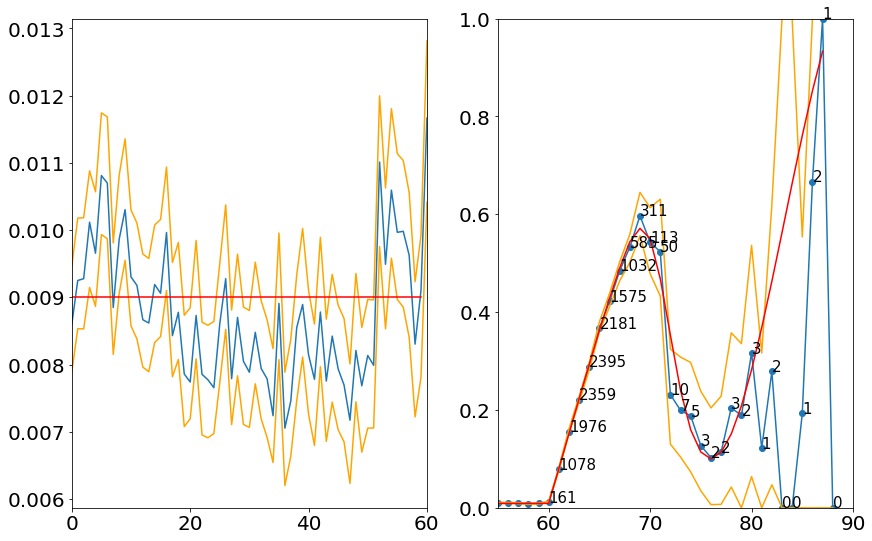

In [350]:
ml = np.array([max((pm[n] - stdevs[n]) / (1-sum(pm[:n])),0) for n in range(1, 90)])
mr = np.array([min((pm[n] + stdevs[n]) / (1-sum(pm[:n])),1) for n in range(1, 90)])
mr[pm[1::]==0] = 1

plt.subplot(121)
plt.plot(margins[:61])
plt.plot(mr[:61], color='orange')
plt.plot(ml[:61], color='orange')

plt.plot([phw(w) for w in range(2, 62)], color='red')
plt.xlim(0, 60)

plt.subplot(122)
plt.plot(margins, marker='o')

plt.plot(mr, color='orange')
plt.plot(ml, color='orange')

plt.plot([phw(w) for w in range(2, 90)], color='red')

for n in range(60, 89):
    an = paimonmoe[n+1] + paaaaaaaa[n+1]
    plt.annotate(f'{an}', (n, margins[n]), size=15)

# plt.plot([76,76],[0,1])
# plt.xlim(0, 60)
# plt.ylim(0, .012)
plt.xlim(55,90)
plt.ylim(0, 1)
# plt.plot([w_5s(w) for w in range(90)])

plt.savefig('paimonmoe_w5_margin.png')

In [281]:
e_5s_multi = distr.MultiDistr(e_5s, 90)

In [289]:
e_5s_multi.std

24.340531096484224

In [302]:
muu, stdd = e_5s_multi.mean*20, e_5s_multi.std*np.sqrt(20)

In [303]:
gus = [np.exp(-0.5*(muu - w)**2 / stdd/stdd) / np.sqrt(2*np.pi) / stdd for w in range(90*20+1)]

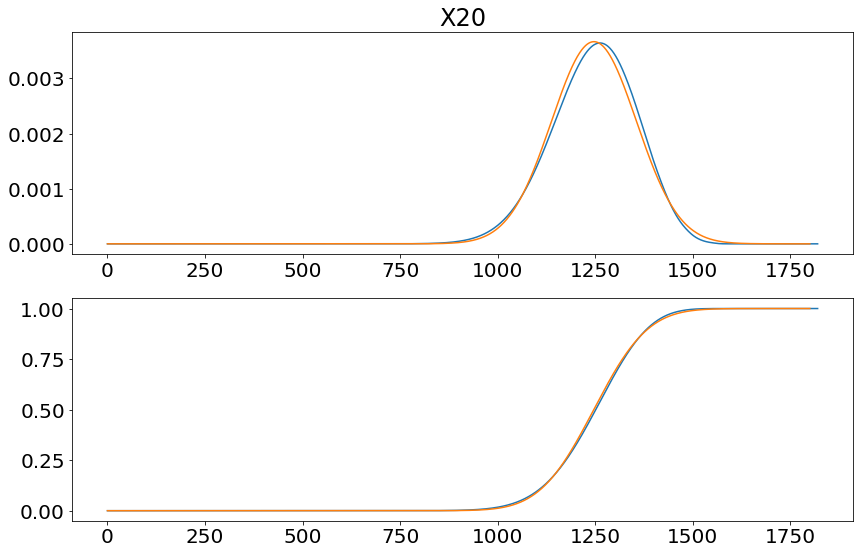

In [313]:
plt.subplot(211)
plt.plot(e_5s_multi.get_distr(20, force_exact=True))
plt.plot(gus)
plt.title('X20')

plt.subplot(212)
plt.plot(np.cumsum(e_5s_multi.get_distr(20, force_exact=True)))
plt.plot(np.cumsum(gus))

plt.savefig('pdfcdf20_cmp.png')

0.018840313137865605

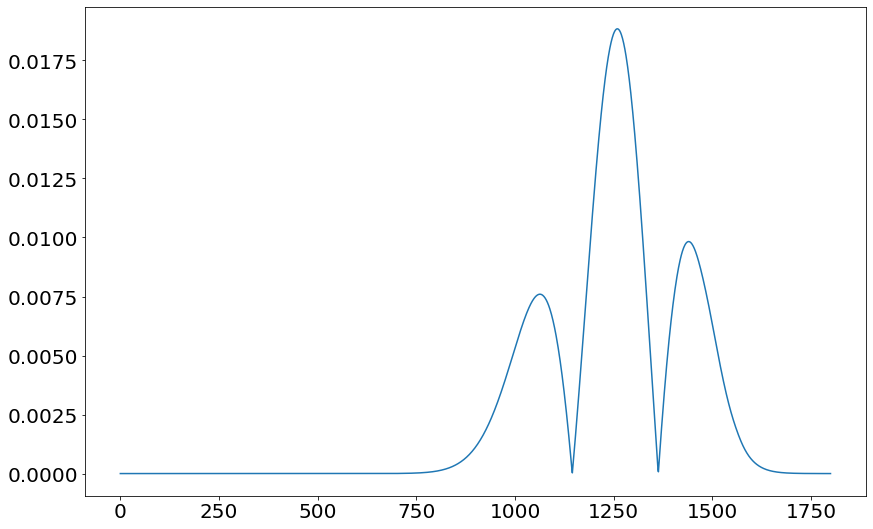

In [315]:
rrr = np.abs(np.cumsum(e_5s_multi.get_distr(20, force_exact=True))[:1800] - np.cumsum(gus)[:1800])
plt.plot(rrr)
np.amax(rrr)
# plt.savefig('20sub.png')

In [197]:
phw(74)

0.06447058823529411

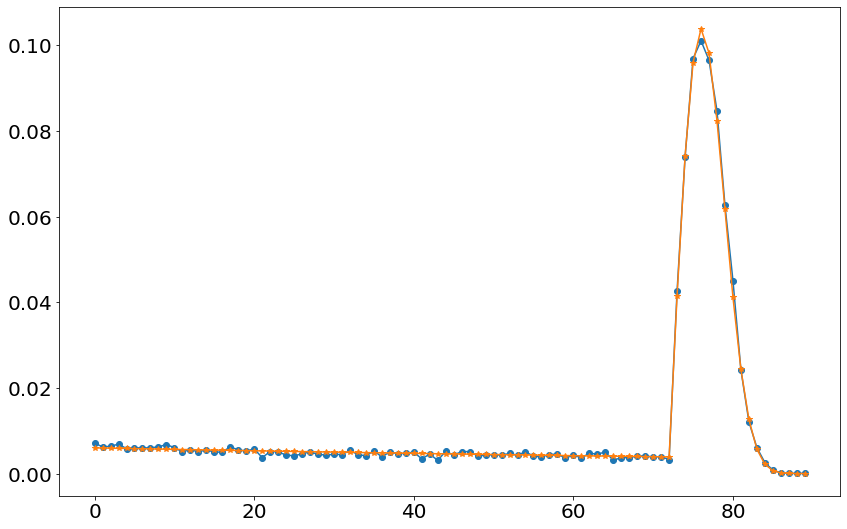

In [210]:
plt.plot(pm, marker='o')
plt.plot([px(w) for w in range(1, 91)], marker='*')
plt.savefig('paimon_cmp.png')

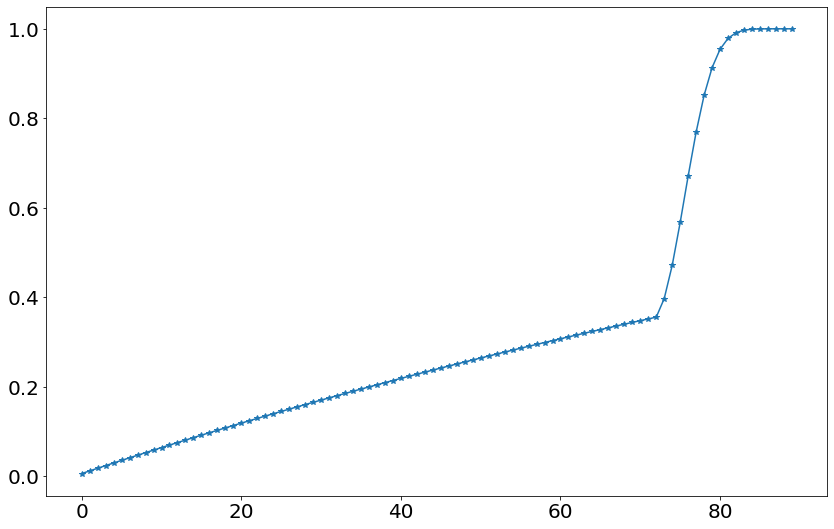

In [218]:
plt.plot(np.cumsum([px(w) for w in range(1, 91)]), marker='*')
plt.savefig('e5_cdf1.png')

In [214]:
np.sqrt(np.sum((pm - [px(w) for w in range(1, 91)])**2))

0.007721980034151069

In [215]:
np.sum(np.abs(pm - [px(w) for w in range(1, 91)]))

0.04914159710584643

In [149]:
stdevs = np.sqrt(pm * (1-pm) / sum(paimonmoe))
margins = [pm[n] / (1-sum(pm[:n])) for n in range(2, 90)]

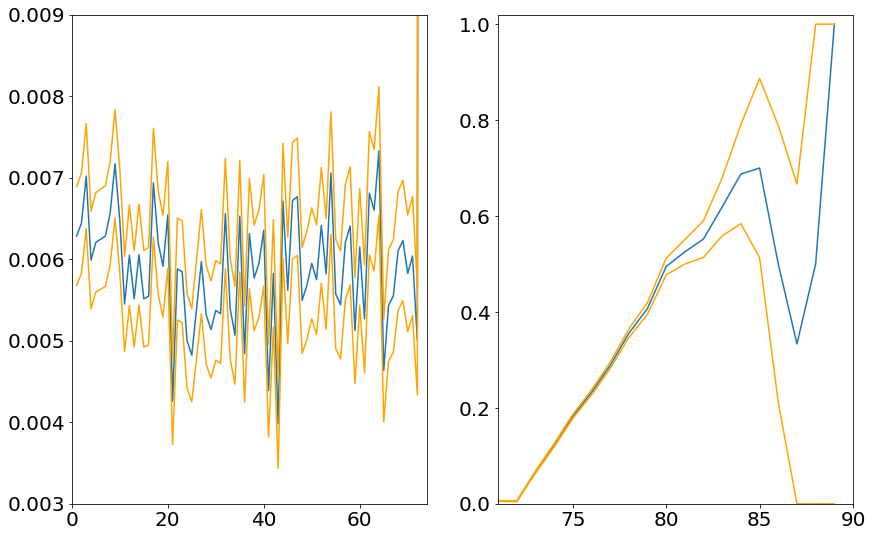

In [180]:
plt.subplot(221)
plt.plot(np.arange(90)+1, pm)

plt.subplot(222)
plt.plot(np.arange(90)+1, pm)
plt.xlim(73, 90)

plt.subplot(121)
margins = [pm[n] / (1-sum(pm[:n])) for n in range(1, 90)]
marginserrl = [max((pm[n] - stdevs[n]) / (1-sum(pm[:n])),0) for n in range(1, 90)]
marginserru = [min((pm[n] + stdevs[n]) / (1-sum(pm[:n])),1) for n in range(1, 90)]
plt.plot(np.arange(89)+1,margins)
plt.plot(np.arange(89)+1,marginserrl, color='orange')
plt.plot(np.arange(89)+1,marginserru, color='orange')
plt.xlim(0, 74)
plt.ylim(.003, .009)

plt.subplot(122)
plt.plot(np.arange(89)+1,margins)
plt.plot(np.arange(89)+1,marginserrl, color='orange')
plt.plot(np.arange(89)+1,marginserru, color='orange')
plt.xlim(71,90)
plt.ylim(0,1.02)

plt.savefig('paimonmoe.png')

In [106]:
sum(e_5s_multi.get_distr(1)[:73]), 1-(1-.006)**72, sum(pm[:73])

(0.3516348300231231, 0.35163483002312357, 0.3506675217163178)

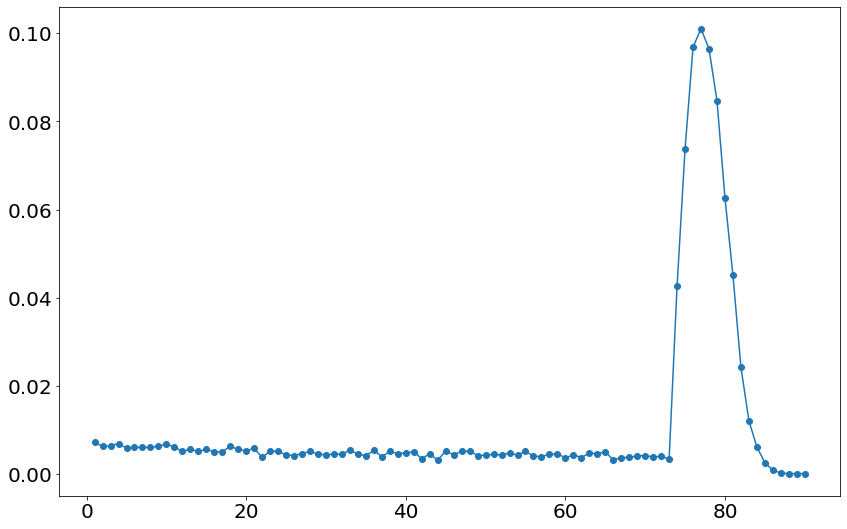

In [146]:
plt.plot(np.arange(90)+1, pm, marker='o')
# plt.savefig

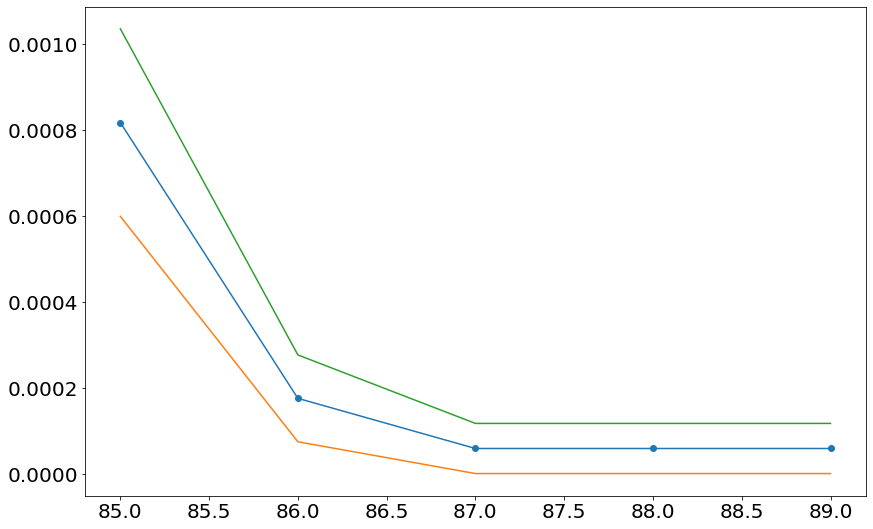

In [143]:
pm = np.array(paimonmoe) / sum(paimonmoe)

stdevs = np.sqrt(pm * (1-pm) / sum(paimonmoe))

plt.plot(np.arange(85, 90), pm[85:], marker='o')
plt.plot(np.arange(85, 90), (pm - stdevs)[85:])
plt.plot(np.arange(85, 90), (pm + stdevs)[85:])
# plt.plot(range(1, 74), e_5s_multi.get_distr(1)[1:74])


In [65]:
errs = np.abs(pm[:73] - e_5s_multi.get_distr(1)[1:74])

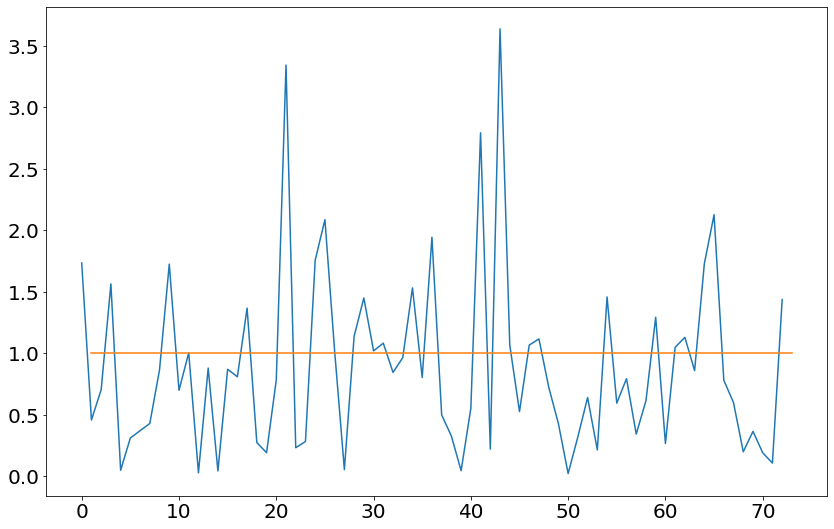

In [70]:
plt.plot(errs / stdevs[:73])
plt.plot([1, 73], [1,1])

In [80]:
1 - np.count_nonzero((errs / stdevs[:73]) > 2) / 73

0.9315068493150684

In [4]:
event_5star = distr.wish_distr(.006, 0.32383924389327824, pity=75, hard=90)
event_4star = distr.wish_distr(.051, 1, pity=9, hard=10)
weap_5star = distr.wish_distr(.007, 0.375056953108059194274565981567885, pity=65, hard=80)
weap_4star = distr.wish_distr(.06, 1, pity=9, hard=10)

In [16]:
e_5s_multi = distr.MultiDistr(event_5star, 90)
e_4s_multi = distr.MultiDistr(event_4star, 10)
w_5s_multi = distr.MultiDistr(weap_5star, 80)
w_4s_multi = distr.MultiDistr(weap_4star, 10)

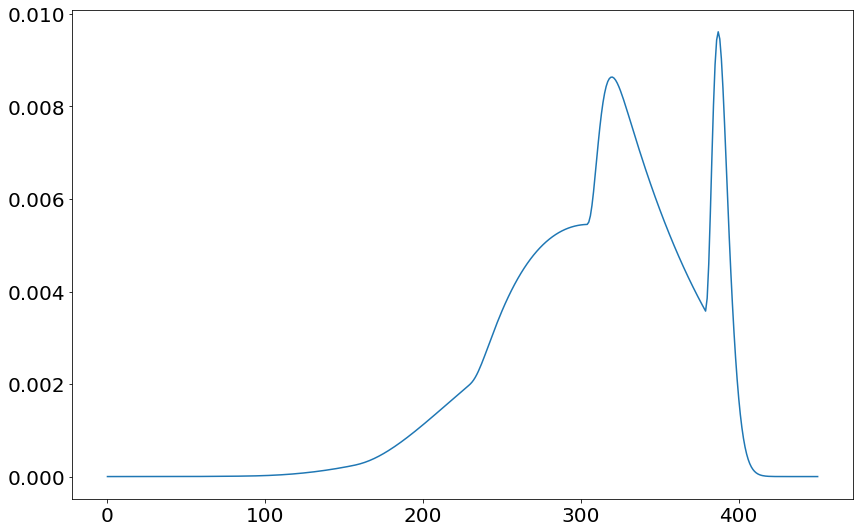

In [18]:
plt.plot([e_5s_multi.p_iter(w, 5) for w in range(90*5+1)])

In [19]:
def e_pan(n: int) -> float:
    if n == 0: return 0

    a2 = -.5 - 2 / (np.sqrt(13))
    a3= -.5 + 2 / (np.sqrt(13))
    l2 = (1+np.sqrt(13))/6
    l3 = (1-np.sqrt(13))/6
    return a2 * (l2-1) * l2**(n-1) + a3 * (l3-1) * l3**(n-1)

@cache
def e_4s_hit(w):
    return sum([e_pan(n) * e_4s_multi.p_iter(w, n) for n in range(w+1)])

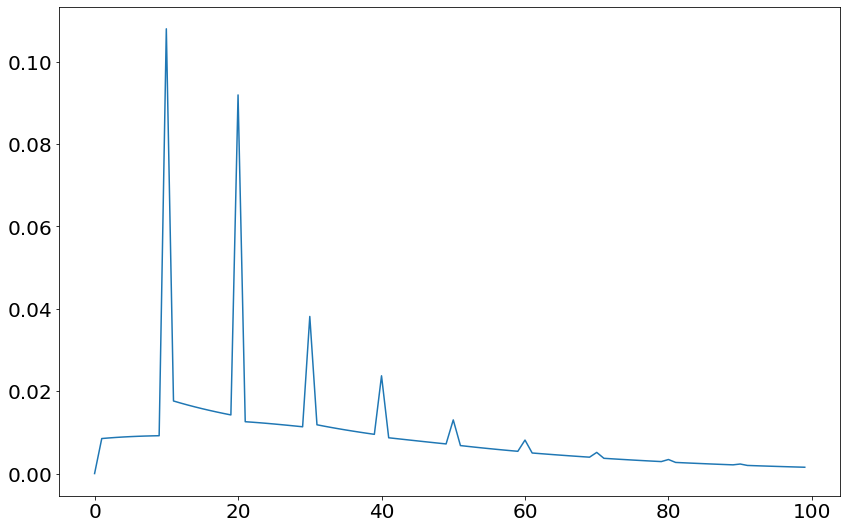

In [20]:
plt.plot([e_4s_hit(w) for w in range(100)])

In [21]:
def w_pan(n: int) -> float:
    if n == 0: return 0

    a2 = -.5 - 11/(4*np.sqrt(29))
    a3 = -.5 + 11/(4*np.sqrt(29))
    l2 = (3+np.sqrt(29)) / 10
    l3 = (3-np.sqrt(29)) / 10
    return a2 * (l2-1) * l2**(n-1) + a3 * (l3-1) * l3**(n-1)

@cache
def w_4s_hit(w):
    return sum([w_pan(n) * w_4s_multi.p_iter(w, n) for n in range(w+1)])

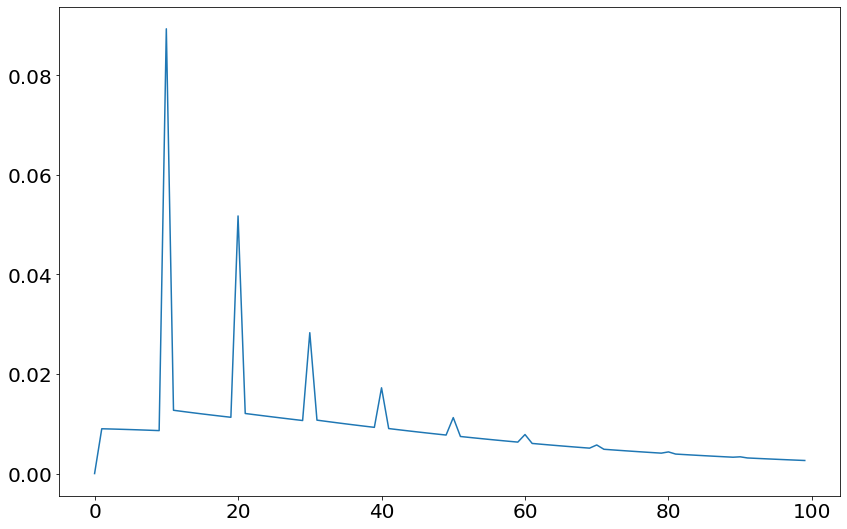

In [22]:
plt.plot([w_4s_hit(w) for w in range(100)])

In [23]:
def w5_pan(n: int) -> float:
    if n == 0: return 0

    a2 = -.5 - 7/(2*np.sqrt(41))
    a3 = -.5 + 7/(2*np.sqrt(41))
    l2 = (3+np.sqrt(41)) / 16
    l3 = (3-np.sqrt(41)) / 16
    return a2 * (l2-1) * l2**(n-1) + a3 * (l3-1) * l3**(n-1)

@cache
def w_5s_hit(w):
    return sum([w5_pan(n) * w_5s_multi.p_iter(w, n) for n in range(w+1)])

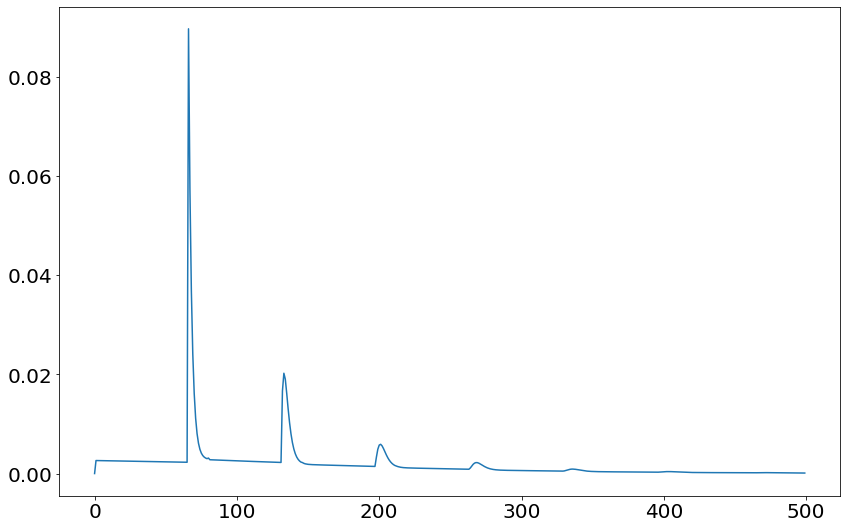

In [40]:
plt.plot([w_5s_hit(w) for w in range(500)])

In [28]:
np.sum([w_5s_hit(w) for w in range(1000)])

0.999898012304135

In [30]:
np.sum(np.arange(1000) * [w_5s_hit(w) for w in range(1000)])

135.02248370913716

In [32]:
cdf = np.cumsum([w_5s_hit(w) for w in range(800)])

In [35]:
np.argmin(np.abs(cdf - .8))

201

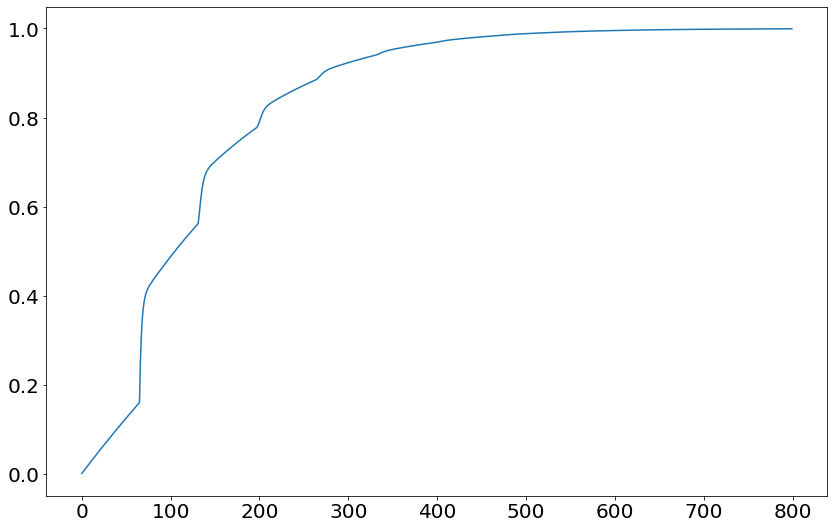

In [29]:
plt.plot(np.cumsum([w_5s_hit(w) for w in range(800)]))
# plt.plot([w_4s_hit(w) for w in range(100)])